In [99]:
%matplotlib inline
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn
import sys
import time

from pandas import DataFrame
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedKFold
from sklearn.base import TransformerMixin
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import SelectKBest
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import f_classif
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import FeatureUnion
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.lda import LDA
from sklearn.linear_model import Lars
from sklearn.linear_model import SGDClassifier
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

In [24]:
data_dict = pickle.load(open("final_project_dataset.pkl", "rb") )

### Holdout
Since the dataset for this project is so small, a hold-out set will not be used, and only k-fold testing and training splits will be used to measure accuracy.

This is because even with a stratified hold-out set of 20%, with only 146 data points, lots of missing data and and 18 poi's, there would be only 3 or so points to do a final test on. This does not give much confidence in the precision of the performance metrics on such a small hold-out set, while also negatively impacting the ability to create the model. 

> "when the number of samples is not large, a strong case can be made that a test set should be avoided because every sample may be needed for model building. (...) Additionally, the size of the test set may not have sufficient power or precision to make reasonable judgements. "

[1] Kuhn M., Kjell J.(2013).  Applied Predictive Modeling. Springer. pp.67

> Hawkins et al. (2003) concisely summarize this point:“holdout samples of  tolerable size [. . . ] do not match the cross-validation itself for reliability in assessing model fit and are hard to motivate.” 

[2]
Hawkins D, Basak S, Mills D (2003). “Assessing Model Fit by Cross–
Validation.” Journal of Chemical Information and Computer Sciences,
43(2), 579–586

This will be addressed with K-fold cross-validation resampling techniques.

### Version 2 - Cross Validation Scheme

1. Define sets of model parameters values to evaluate
2. for each parameter set in grid search DO
  1. For each k-fold resampling iteration DO
    1. Hold-out 1/k samples/fold
    2. Pre-Process Data (Create functions on training set, apply to test set with same)
        1. Impute data (median)
        2. Scale features (x_i - mean))/std
        3. Perform any univariate feature selection (remove very low variation features)
        4. Modeling feature selection (ExtraTreesClassifier) 
    3. Fit the model on the k/K training fold
    4. Predict the hold-out samples/fold
  2. END
  3. Calculate the average performance across hold-out predictions
3. END
4. Determine the optimal parameter set
5. Fit the final model to all training data using the optimal parameter set

### Fix 2 out-of-sync records

In [25]:
data_dict['BELFER ROBERT'] = {'bonus': 'NaN',
                              'deferral_payments': 'NaN',
                              'deferred_income': -102500,
                              'director_fees': 102500,
                              'email_address': 'NaN',
                              'exercised_stock_options': 'NaN',
                              'expenses': 3285,
                              'from_messages': 'NaN',
                              'from_poi_to_this_person': 'NaN',
                              'from_this_person_to_poi': 'NaN',
                              'loan_advances': 'NaN',
                              'long_term_incentive': 'NaN',
                              'other': 'NaN',
                              'poi': False,
                              'restricted_stock': -44093,
                              'restricted_stock_deferred': 44093,
                              'salary': 'NaN',
                              'shared_receipt_with_poi': 'NaN',
                              'to_messages': 'NaN',
                              'total_payments': 3285,
                              'total_stock_value': 'NaN'}

data_dict['BHATNAGAR SANJAY'] = {'bonus': 'NaN',
                                 'deferral_payments': 'NaN',
                                 'deferred_income': 'NaN',
                                 'director_fees': 'NaN',
                                 'email_address': 'sanjay.bhatnagar@enron.com',
                                 'exercised_stock_options': 15456290,
                                 'expenses': 137864,
                                 'from_messages': 29,
                                 'from_poi_to_this_person': 0,
                                 'from_this_person_to_poi': 1,
                                 'loan_advances': 'NaN',
                                 'long_term_incentive': 'NaN',
                                 'other': 'NaN',
                                 'poi': False,
                                 'restricted_stock': 2604490,
                                 'restricted_stock_deferred': -2604490,
                                 'salary': 'NaN',
                                 'shared_receipt_with_poi': 463,
                                 'to_messages': 523,
                                 'total_payments': 137864,
                                 'total_stock_value': 15456290}

In [26]:
df = pd.DataFrame.from_dict(data_dict, orient='index')
df = df.drop('TOTAL', axis=0)

'NaN' was imported as a string instead of a missing value. We will convert these to NaN type and look how many missing values our data has.

In [27]:
# Replace 'NaN' strings with 0's
df = df.replace('NaN', 0)
# Replace email strings with True/False boolean as to whether an email was present or not
# df['email_address'] = df['email_address'].fillna(0).apply(lambda x: x != 0, 1)
# Remove 'email_address' string as a feature
del df['email_address']

In [28]:
df_original = df.copy()

In [29]:
# Convert features to floats since MinMaxScaler does not like int64's
X_original = df.drop(['poi'], axis=1).astype(float)
y_original = df['poi']

# Drop any row that has only zeros in it, drop from labels first, then from features
y_original = y_original[X_original.abs().sum(axis=1) != 0]
X_original = X_original[X_original.abs().sum(axis=1) != 0]

# Save the names of the features 
X_names = X_original.columns
#X_original = X_original.apply(lambda x: x.fillna(0), axis=0)

# Scale the features
standardized = MinMaxScaler().fit_transform(X_original)

# Score the features using a classification scoring function using 
# the Anova F-value for the provided sample
selection = SelectKBest(k='all', score_func=f_classif).fit(standardized, y_original)

#new_X = selection.transform(standardized)

#KBestNames = X_names[selection.get_support()]

# Create a pd.DataFrame of the names and scores
scores = pd.DataFrame([X_names, selection.scores_])
scores = scores.T
scores.columns = ['Features', 'Scores']
scores = scores.sort_values(['Scores'], ascending=False).reset_index(drop=True)
scores

,Features,Scores
0,total_stock_value,22.7821
1,exercised_stock_options,22.6105
2,bonus,21.06
3,salary,18.5757
4,deferred_income,11.5619
5,long_term_incentive,10.0725
6,total_payments,9.38024
7,restricted_stock,8.96496
8,shared_receipt_with_poi,8.74649
9,loan_advances,7.24273


In [30]:
topKBest = list(scores.Features[0:17])
topKBest

['total_stock_value',
 'exercised_stock_options',
 'bonus',
 'salary',
 'deferred_income',
 'long_term_incentive',
 'total_payments',
 'restricted_stock',
 'shared_receipt_with_poi',
 'loan_advances',
 'expenses',
 'from_poi_to_this_person',
 'other',
 'from_this_person_to_poi',
 'director_fees',
 'to_messages',
 'restricted_stock_deferred']

TOP10: 
 ['exercised_stock_options', 'deferred_income', 'total_stock_value', 'bonus', 'other', 'expenses', 'restricted_stock', 'shared_receipt_with_poi', 'from_this_person_to_poi']
                           Importance
exercised_stock_options      0.097494
deferred_income              0.087140
total_stock_value            0.085832
bonus                        0.080128
other                        0.070522
expenses                     0.069462
restricted_stock             0.059565
shared_receipt_with_poi      0.059027
from_this_person_to_poi      0.058577
salary                       0.058400
total_payments               0.057111
from_poi_to_this_person      0.053071
long_term_incentive          0.052587
to_messages                  0.036775
from_messages                0.032688
deferral_payments            0.024017
restricted_stock_deferred    0.008625
loan_advances                0.007719
director_fees                0.001263


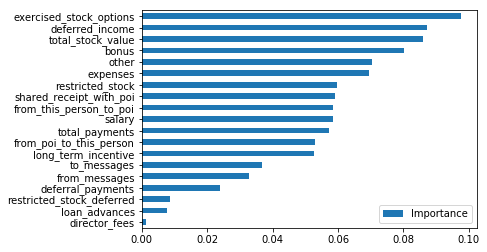

In [31]:
ET_selection = ExtraTreesClassifier(n_estimators=1000).fit(standardized, y_original)
#print ET_selection.feature_importances_

ET_new_X = selection.transform(standardized)

# Create a pd.DataFrame of the names and importances
scores = pd.DataFrame(ET_selection.feature_importances_, index=X_names)
#scores = scores.T

scores.columns = ['Importance']
scores = scores.sort_values(['Importance'], ascending=False)
print ("TOP10: \n", list(scores.index[0:9]))
print (scores)
scores.sort_values(['Importance'], ascending=True).plot(kind='barh')

In [32]:
for i in range(10): 
    sys.stdout.write('{0}..'.format(i)) 
    sys.stdout.flush() 
    time.sleep(.1)

0..1..2..3..4..5..6..7..8..9..

In [33]:
# Replace with index watcher
# A quick look at the original finanical spreadsheet shows TOTAL at the bottom 
# totaling all entries for everyone. This is obviously an outlier with no 
# meaningful information and can be removed.

# df[df['salary'] > 1000000]
# df[df.index == 'TOTAL']
#df = df.drop('TOTAL', axis=0)

By default, the GridSearchCV uses a 3-fold cross-validation. However, if it detects that a classifier is passed, rather than a regressor, it uses a stratified 3-fold.

http://scikit-learn.org/stable/tutorial/statistical_inference/model_selection.html

## Remove columns with less than 50% of entries present.
## Remove rows with no non-NA values

In [34]:
# low_var_remover = VarianceThreshold(threshold=.5)

In [35]:
# ************************
# Encode as 0 instead.
# Remove columns with more than 50% NA's
# df_50 = df.dropna(axis=1, thresh=len(df)/2)
# ************************

# Since email_address and poi are True/False, every record should have at least 2 non-NA.
# We'll next remove any rows that don't have at least 2 non-NA values besides these.
# The criteria is: No more than 11 NA's per row.
# df_50 = df_50.dropna(axis=0, thresh=5)

# 128 records remain.
# df_50.info()

### Financial NA's

When looking at the source of the data, the NA entries in the financial data seem values that are reported as zero since all payments/stock values add up to the total payments/stocks values. These NA values should then be set to 0 to add up to the totals reported by the accounting spreadsheet.

### Email statistics NA's

The missing values for NA's for email statistics may be a little more subjective. 

 1. Some email statistics are features created with prior knowledge of the entire dataset (i.e. emails to/from poi's). This may be data snooping, since if new data/pois were somehow introduced, it would not be possible to generate these features without prior knowledge of which new data were the poi's.

 2. NA's here imply that the person did not have an email account with Enron, or were not involved in emailing by some other way.
 
This means all email data features ar NA if even one column had missing email data for that person. It is hard to judge any distribution that they could have if they were given an email account since they have no ties to the financial data to infer distributions. 
 
We have no real way to infer a person having sent/recieved 10 emails or 10,000 from completely unrelated financial data from a different dataset with many different people.

For this reason, these NA will also be encoded as 0.

In [36]:
df = df.apply(lambda x: x.fillna(0), axis=0)

## Imputation

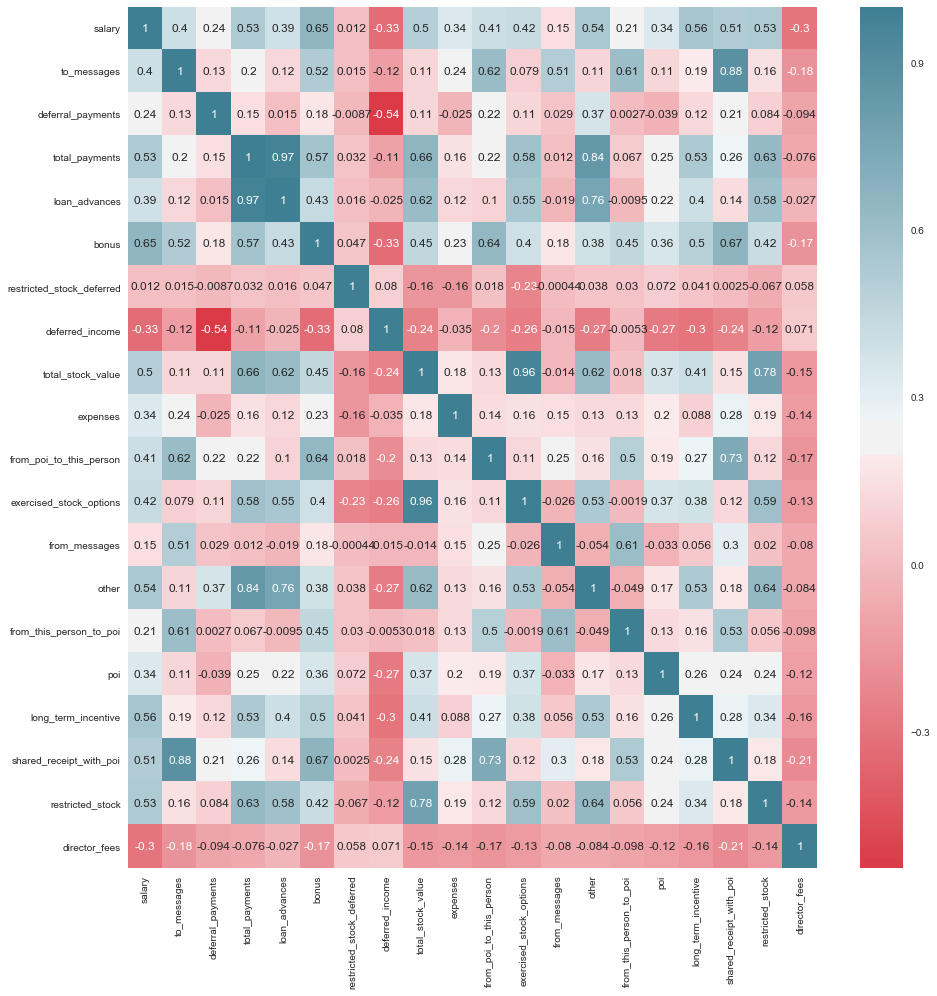

In [40]:
import seaborn as sns
sns.set(style='darkgrid')

f, ax = plt.subplots(figsize=(14, 14))
cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.heatmap(df.corr(), annot=True, cmap=cmap, ax=ax)
f.tight_layout()

In [41]:
corrs = df.corr()
corrs.sort_values(['poi'], ascending=False)['poi']

poi                          1.000000
total_stock_value            0.372603
exercised_stock_options      0.371336
bonus                        0.360262
salary                       0.341365
long_term_incentive          0.258301
total_payments               0.249394
restricted_stock             0.244578
shared_receipt_with_poi      0.242105
loan_advances                0.220405
expenses                     0.195503
from_poi_to_this_person      0.191549
other                        0.170443
from_this_person_to_poi      0.130319
to_messages                  0.110006
restricted_stock_deferred    0.071629
from_messages               -0.033302
deferral_payments           -0.038635
director_fees               -0.120144
deferred_income             -0.274998
Name: poi, dtype: float64

In [42]:
# Pick a column which we are predicting.
# Find other variables correlated to used KMeansNeighborsRegression to predict/impute
# the missing values.
# df_50.corr().ix[: ,'salary']

In [43]:
# cols1 = ['salary', 'other', 'total_stock_value', 'exercised_stock_options', 
#        'total_payments', 'restricted_stock']
# Bonus and salary values don't seem to be missing at random. Anytime there is a null value
# for salary, there is also one for bonus. So bonus can't be used to predict salary on
# the first pass. Predicted salary values will be used to predict bonus values though 
# on a second pass.
# cols2= ['salary', 'other', 'total_stock_value', 'exercised_stock_options', 
#        'total_payments', 'restricted_stock', 'bonus']
# cols3 = ['to_messages', 'from_this_person_to_poi', 'from_messages', 
# 'shared_receipt_with_poi', 'from_poi_to_this_person']

In [44]:
def kcluster_null(df=None, cols=None, process_all=True):
    '''
    Input: Takes pandas dataframe with values to impute, and a list of columns to impute
        and use for imputing.
    Returns: Pandas dataframe with null values imputed for list of columns passed in.
    
    # Ideally columns should be somewhat correlated since they will be used in KNN to
    # predict each other, one column at a time.
    
    '''
    
    # Create a KNN regression estimator for 
    income_imputer = KNeighborsRegressor(n_neighbors=1)
    # Loops through the columns passed in to impute each one sequentially.
    
    if not process_all:
        to_pred = cols[0]
        predictor_cols = cols[1:]
        
        
    for each in cols:
        # Create a temp list that does not include the column being predicted.
        temp_cols = [col for col in cols if col != each]
        # Create a dataframe that contains no missing values in the columns being predicted.
        # This will be used to train the KNN estimator.
        df_col = df[df[each].isnull()==False]
        
        # Create a dataframe with all of the nulls in the column being predicted.
        df_null_col = df[df[each].isnull()==True]
        
        # Create a temp dataframe filling in the medians for each column being used to
        # predict that is missing values.
        # This step is needed since we have so many missing values distributed through 
        # all of the columns.
        temp_df_medians = df_col[temp_cols].apply(lambda x: x.fillna(x.median()), axis=0)
        
        # Fit our KNN imputer to this dataframe now that we have values for every column.
        income_imputer.fit(temp_df_medians, df_col[each])
        
        # Fill the df (that has null values being predicted) with medians in the other
        # columns not being predicted.
        # ** This currently uses its own medians and should ideally use the predictor df's
        # ** median values to fill in NA's of columns being used to predict.
        temp_null_medians = df_null_col[temp_cols].apply(lambda x: x.fillna(x.median()), axis=0)
        
        # Predict the null values for the current 'each' variable.
        new_values = income_imputer.predict(temp_null_medians[temp_cols])

        # Replace the null values of the original null dataframe with the predicted values.
        df_null_col[each] = new_values
        
        # Append the new predicted nulls dataframe to the dataframe which containined
        # no null values.
        # Overwrite the original df with this one containing predicted columns. 
        # Index order will not be preserved since it is rearranging each time by 
        # null values.
        df = df_col.append(df_null_col)
        
    # Returned final dataframe sorted by the index names.
    return df.sort_index(axis=0)

In [46]:
df.iloc[127]

salary                            0
to_messages                       0
deferral_payments                 0
total_payments               362096
loan_advances                     0
bonus                             0
restricted_stock_deferred         0
deferred_income                   0
total_stock_value                 0
expenses                          0
from_poi_to_this_person           0
exercised_stock_options           0
from_messages                     0
other                        362096
from_this_person_to_poi           0
poi                           False
long_term_incentive               0
shared_receipt_with_poi           0
restricted_stock                  0
director_fees                     0
Name: THE TRAVEL AGENCY IN THE PARK, dtype: object

In [47]:
#cols = [x for x in df.columns]
#for each in cols:
#    g = sns.FacetGrid(df, col='poi', margin_titles=True, size=6)
#    g.map(plt.hist, each, color='steelblue')

In [48]:
from pandas.tools.plotting import scatter_matrix

In [49]:
list(df.columns)

['salary',
 'to_messages',
 'deferral_payments',
 'total_payments',
 'loan_advances',
 'bonus',
 'restricted_stock_deferred',
 'deferred_income',
 'total_stock_value',
 'expenses',
 'from_poi_to_this_person',
 'exercised_stock_options',
 'from_messages',
 'other',
 'from_this_person_to_poi',
 'poi',
 'long_term_incentive',
 'shared_receipt_with_poi',
 'restricted_stock',
 'director_fees']

In [56]:
financial_cols = np.array(['salary', 'deferral_payments', 'total_payments', 'exercised_stock_options', 
                  'bonus', 'restricted_stock', 'restricted_stock_deferred', 'total_stock_value',
                  'expenses', 'loan_advances', 'other', 'director_fees', 'deferred_income', 
                  'long_term_incentive'])

email_cols = np.array(['from_messages', 'to_messages', 'shared_receipt_with_poi', 
              'from_this_person_to_poi', 'from_poi_to_this_person'])

In [57]:
from sklearn.ensemble import RandomForestClassifier

In [58]:
clf = RandomForestClassifier(n_estimators=1000)
clf.fit(df[financial_cols], df['poi'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [59]:
importances = clf.feature_importances_
sorted_idx = np.argsort(importances)

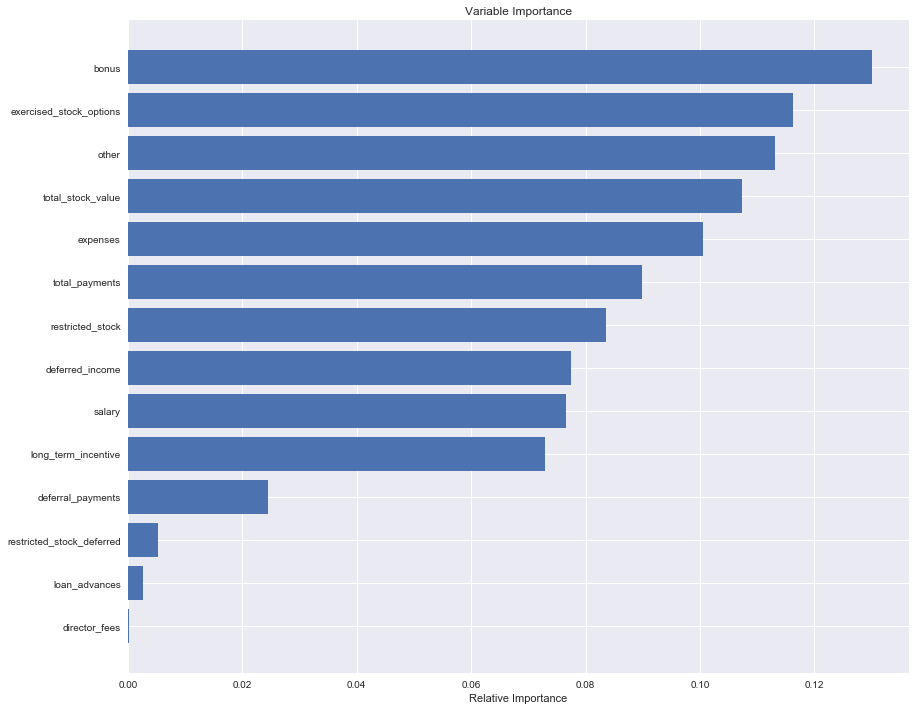

In [60]:
padding = np.arange(len(financial_cols)) + 0.5
plt.figure(figsize=(14, 12))
plt.barh(padding, importances[sorted_idx], align='center')
plt.yticks(padding, financial_cols[sorted_idx])
plt.xlabel("Relative Importance")
plt.title("Variable Importance")
plt.show()

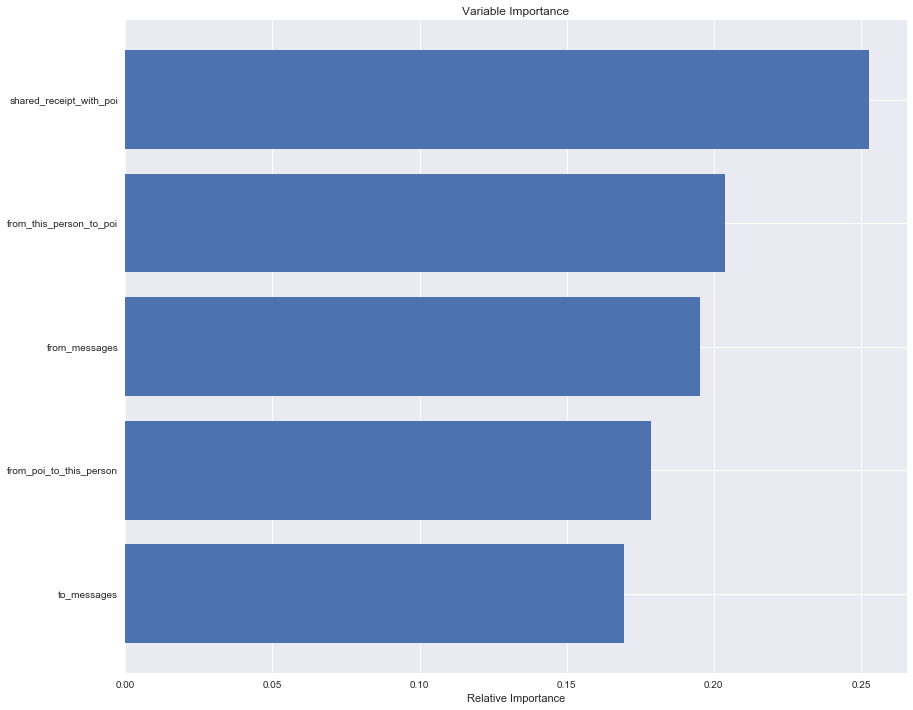

In [61]:
clf = RandomForestClassifier(n_estimators=1000)
clf.fit(df[email_cols], df['poi'])

importances = clf.feature_importances_
sorted_idx = np.argsort(importances)

padding = np.arange(len(email_cols)) + 0.5
plt.figure(figsize=(14, 12))
plt.barh(padding, importances[sorted_idx], align='center')
plt.yticks(padding, email_cols[sorted_idx])
plt.xlabel("Relative Importance")
plt.title("Variable Importance")
plt.show()

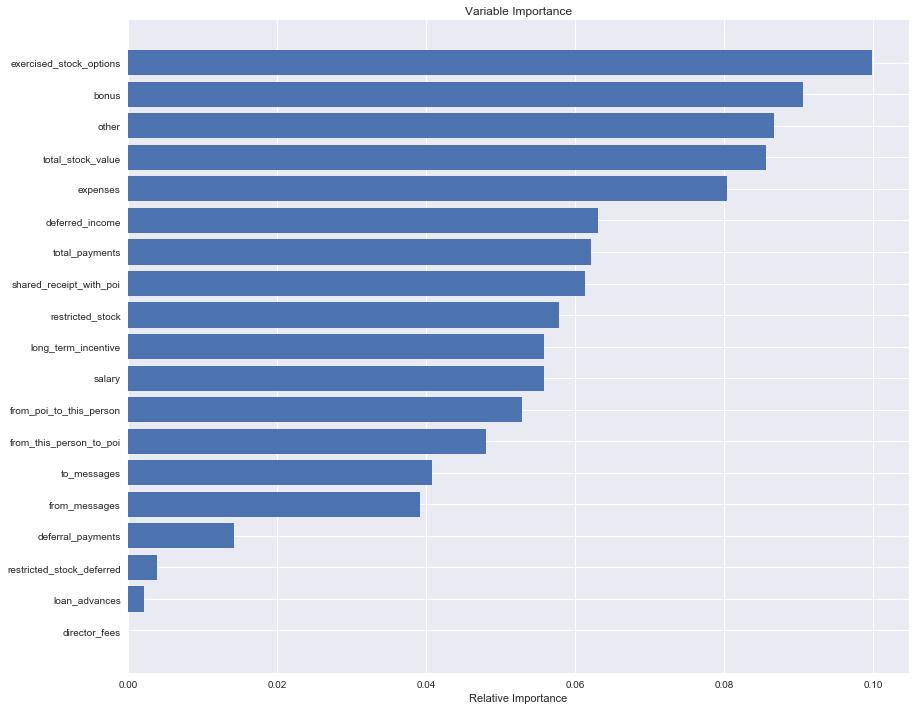

In [62]:
all_cols = np.concatenate([email_cols, financial_cols])
clf = RandomForestClassifier(n_estimators=1000)
clf.fit(df[all_cols], df['poi'])

importances = clf.feature_importances_
sorted_idx = np.argsort(importances)

padding = np.arange(len(all_cols)) + 0.5
plt.figure(figsize=(14, 12))
plt.barh(padding, importances[sorted_idx], align='center')
plt.yticks(padding, all_cols[sorted_idx])
plt.xlabel("Relative Importance")
plt.title("Variable Importance")
plt.show()

In [63]:
df['ex_stock_bins'] = pd.cut(df.exercised_stock_options, bins=15, labels=False)
pd.value_counts(df.ex_stock_bins)

0     118
1      10
2       6
3       4
8       2
6       2
14      1
13      1
4       1
Name: ex_stock_bins, dtype: int64

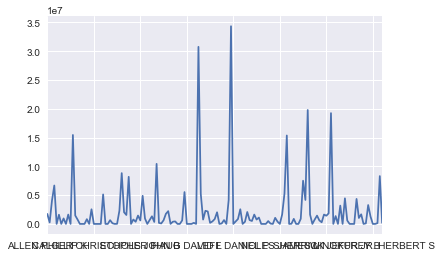

In [64]:
df.exercised_stock_options.plot()

In [65]:
def capValues(x, cap):
    return (cap if x > cap else x)

In [66]:
df.exercised_stock_options = df.exercised_stock_options.apply(lambda x: capValues(x, 5000000))

In [67]:
df['ex_stock_bins'] = pd.cut(df.exercised_stock_options, bins=15, labels=False)
pd.value_counts(df.ex_stock_bins)

0     60
1     18
14    17
2     13
4     12
6      7
3      5
5      4
12     3
13     2
9      2
7      2
Name: ex_stock_bins, dtype: int64

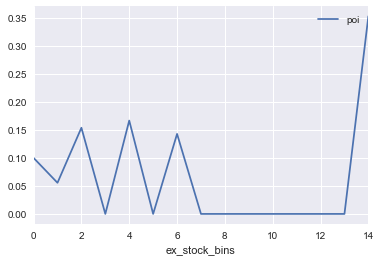

In [68]:
df[['ex_stock_bins', 'poi']].groupby('ex_stock_bins').mean().plot()

In [69]:
df.columns

Index(['salary', 'to_messages', 'deferral_payments', 'total_payments',
       'loan_advances', 'bonus', 'restricted_stock_deferred',
       'deferred_income', 'total_stock_value', 'expenses',
       'from_poi_to_this_person', 'exercised_stock_options', 'from_messages',
       'other', 'from_this_person_to_poi', 'poi', 'long_term_incentive',
       'shared_receipt_with_poi', 'restricted_stock', 'director_fees',
       'ex_stock_bins'],
      dtype='object')

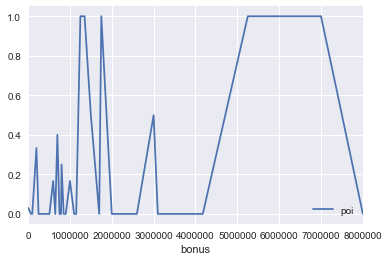

In [70]:
df[['bonus', 'poi']].groupby('bonus').mean().plot()

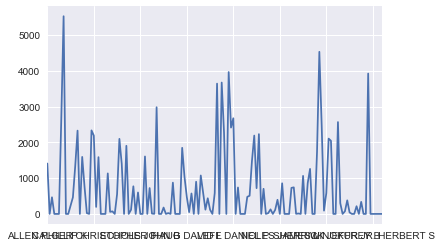

In [71]:
df.shared_receipt_with_poi.plot()

In [72]:
max(df.shared_receipt_with_poi)

5521

In [74]:
# Create bins for shared receipt with poi
my_bins = [min(df.shared_receipt_with_poi)] + [250]
for i in range(500, 5000, 500):
    my_bins = my_bins + [i]
    
my_bins = my_bins + [max(df.shared_receipt_with_poi)]
df['shared_poi_bins'] = pd.cut(df.shared_receipt_with_poi, bins=my_bins, labels=False, include_lowest=True)
pd.value_counts(df['shared_poi_bins'])

0     81
2     19
5     11
3      9
1      9
4      6
8      4
6      4
10     2
Name: shared_poi_bins, dtype: int64

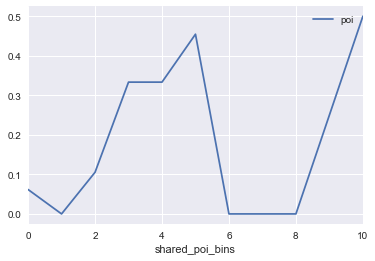

In [75]:
df[['shared_poi_bins', 'poi']].groupby('shared_poi_bins').mean().plot()

In [76]:
df.total_stock_value

ALLEN PHILLIP K                   1729541
BADUM JAMES P                      257817
BANNANTINE JAMES M                5243487
BAXTER JOHN C                    10623258
BAY FRANKLIN R                      63014
BAZELIDES PHILIP J                1599641
BECK SALLY W                       126027
BELDEN TIMOTHY N                  1110705
BELFER ROBERT                           0
BERBERIAN DAVID                   2493616
BERGSIEKER RICHARD P               659249
BHATNAGAR SANJAY                 15456290
BIBI PHILIPPE A                   1843816
BLACHMAN JEREMY M                  954354
BLAKE JR. NORMAN P                      0
BOWEN JR RAYMOND M                 252055
BROWN MICHAEL                           0
BUCHANAN HAROLD G                 1014505
BUTTS ROBERT H                     417619
BUY RICHARD B                     3444470
CALGER CHRISTOPHER F               126027
CARTER REBECCA C                        0
CAUSEY RICHARD A                  2502063
CHAN RONNIE                       

In [77]:
from sklearn.preprocessing import StandardScaler

df['total_stock_scaled'] = StandardScaler().fit_transform(df[['total_stock_value']])
df['bonus_scaled'] = StandardScaler().fit_transform(df[['bonus']])

print df.total_stock_scaled.describe()
plt.hist(df.total_stock_scaled)

In [78]:
def dont_neg_log(x):
    if x >=0:
        return np.log1p(x)
    else:
        return 0
    
df['stock_log'] = df['total_stock_value'].apply(lambda x: dont_neg_log(x))

## Feature Ratio Creation

In [79]:
financial_cols = np.array(['salary', 'deferral_payments', 'total_payments', 'exercised_stock_options', 
                  'bonus', 'restricted_stock', 'restricted_stock_deferred', 'total_stock_value',
                  'expenses', 'loan_advances', 'other', 'director_fees', 'deferred_income', 
                  'long_term_incentive'])

email_cols = np.array(['from_messages', 'to_messages', 'shared_receipt_with_poi', 
              'from_this_person_to_poi', 'from_poi_to_this_person', 'email_address'])

In [80]:
payment_comp = ['salary', 'deferral_payments','bonus', 'expenses', 'loan_advances',
                'other', 'director_fees', 'deferred_income', 'long_term_incentive']
payment_total = ['total_payments']

stock_comp = ['exercised_stock_options', 'restricted_stock','restricted_stock_deferred',]
stock_total = ['total_stock_value']

all_comp = payment_comp + stock_comp

email_comp = ['shared_receipt_with_poi', 'from_this_person_to_poi', 'from_poi_to_this_person' ]
email_totals = ['from_messages', 'to_messages'] # interaction_w_poi = total(from/to/shared poi)

In [81]:
df['total_compensation'] = df['total_payments'] + df['total_stock_value']

for each in payment_comp:
    df['{0}_{1}_ratio'.format(each, 'total_pay')] = df[each]/df['total_payments']

for each in stock_comp:
    df['{0}_{1}_ratio'.format(each, 'total_stock')] = df[each]/df['total_stock_value']

for each in all_comp:
    df['{0}_{1}_ratio'.format(each, 'total_compensation')] = df[each]/df['total_compensation']

    
df['total_poi_interaction'] = df['shared_receipt_with_poi'] + df['from_this_person_to_poi'] + \
df['from_poi_to_this_person']

for each in email_comp:
    df['{0}_{1}_ratio'.format(each, 'total_poi_int')] = df[each]/df['total_poi_interaction']

df['total_active_poi_interaction'] = df['from_this_person_to_poi'] + df['from_poi_to_this_person']
df['to_poi_total_active_poi_ratio'] = df['from_this_person_to_poi']/df['total_active_poi_interaction']
df['from_poi_total_active_poi_ratio'] = df['from_poi_to_this_person']/df['total_active_poi_interaction']

df['to_messages_to_poi_ratio'] = df['from_this_person_to_poi']/ df['to_messages']
df['from_messages_from_poi_ratio'] = df['from_poi_to_this_person']/df['from_messages']
df['shared_poi_from_messages_ratio'] = df['shared_receipt_with_poi']/df['from_messages']
df['shared_poi_total_compensation'] = df['shared_receipt_with_poi']/df['total_compensation']
df['bonus_by_total_stock'] = df['bonus']/df['total_stock_value']

## Add squared features
for each in all_comp:
    df['{0}_squared'.format(each)] = df[each]**2
    
for each in email_comp:
    df['{0}_squared'.format(each)] = df[each]**2

A good portion of people were paid either only in stock or payments.
Another good portion also didn't have email statistics available.

These ratios will need to be set to zero manually due to division by 0 - NaN.

In [82]:
df = df.apply(lambda x: x.fillna(0), axis=0)

In [83]:
df[['poi', 'director_fees_total_pay_ratio', 'director_fees', 'total_payments']]

,poi,director_fees_total_pay_ratio,director_fees,total_payments
ALLEN PHILLIP K,False,0.000000,0,4484442
BADUM JAMES P,False,0.000000,0,182466
BANNANTINE JAMES M,False,0.000000,0,916197
BAXTER JOHN C,False,0.000000,0,5634343
BAY FRANKLIN R,False,0.000000,0,827696
BAZELIDES PHILIP J,False,0.000000,0,860136
BECK SALLY W,False,0.000000,0,969068
BELDEN TIMOTHY N,True,0.000000,0,5501630
BELFER ROBERT,False,31.202435,102500,3285
BERBERIAN DAVID,False,0.000000,0,228474


In [84]:
df[df['poi']==True]

,salary,to_messages,deferral_payments,total_payments,loan_advances,bonus,restricted_stock_deferred,deferred_income,total_stock_value,expenses,...,other_squared,director_fees_squared,deferred_income_squared,long_term_incentive_squared,exercised_stock_options_squared,restricted_stock_squared,restricted_stock_deferred_squared,shared_receipt_with_poi_squared,from_this_person_to_poi_squared,from_poi_to_this_person_squared
BELDEN TIMOTHY N,213999,7991,2144013,5501630,0,5249999,0,-2334434,1110705,17355,...,44393647204,0,5449582100356,0,908468234496,24827989761,0,30481441,11664,51984
BOWEN JR RAYMOND M,278601,1858,0,2669589,0,1350000,0,-833,252055,65907,...,2627641,0,693889,949246849849,0,63531723025,0,2537649,225,19600
CALGER CHRISTOPHER F,240189,2598,0,1639297,0,1250000,0,-262500,126027,35818,...,236196,0,68906250000,140853092416,0,15882804729,0,4787344,625,39601
CAUSEY RICHARD A,415189,1892,0,1868758,0,1000000,0,-235000,2502063,30674,...,94799331025,0,55225000000,122500000000,0,6260319255969,0,2512225,144,3364
COLWELL WESLEY,288542,1758,27610,1490344,0,1200000,0,-144062,698242,16514,...,10351027600,0,20753859844,0,0,487541890564,0,1281424,121,57600
DELAINEY DAVID W,365163,3093,0,4747979,0,3000000,0,0,3614261,86174,...,2758921,0,0,1676975790361,5249198778769,1750720629904,0,4397409,370881,4356
FASTOW ANDREW S,440698,0,0,2424083,0,1300000,0,-1386055,1794412,55921,...,76986271296,0,1921148463025,3013886963025,0,3219914425744,0,0,0,0
GLISAN JR BEN F,274975,873,0,1272284,0,600000,0,0,778546,125978,...,40123294864,0,0,5044266529,148015633984,155092617124,0,763876,36,2704
HANNON KEVIN P,243293,1045,0,288682,0,1500000,0,-3117011,6391065,34039,...,128822500,0,9715757574121,2614724574121,25000000000000,727718188096,0,1071225,441,1024
HIRKO JOSEPH,0,0,10259,91093,0,0,0,0,30766064,77978,...,8156736,0,0,0,25000000000000,0,0,0,0,0


director_fees_total_pay_ratio, 
deferred_income_total_pay_ratio,
exercised_stock_options_total_stock_ratio, exercised_stock_options_total_stock_ratio,
restricted_stock_deferred_total_stock_ratio,
restricted_stock_total_stock_ratio,
director_fees_total_compensation_ratio,
deferred_income_total_compensation_ratio,
restricted_stock_total_compensation_ratio,
restricted_stock_deferred_total_compensation_ratio 

## Replace Inf/-Inf created in pandas from dividing a -/+ number by zero

In [85]:
df = df.replace([np.inf, -np.inf], 0)

In [86]:
#df.ix[20:30, 30:40]

In [87]:
# Column/row slicing by number
# df.ix[11,:]

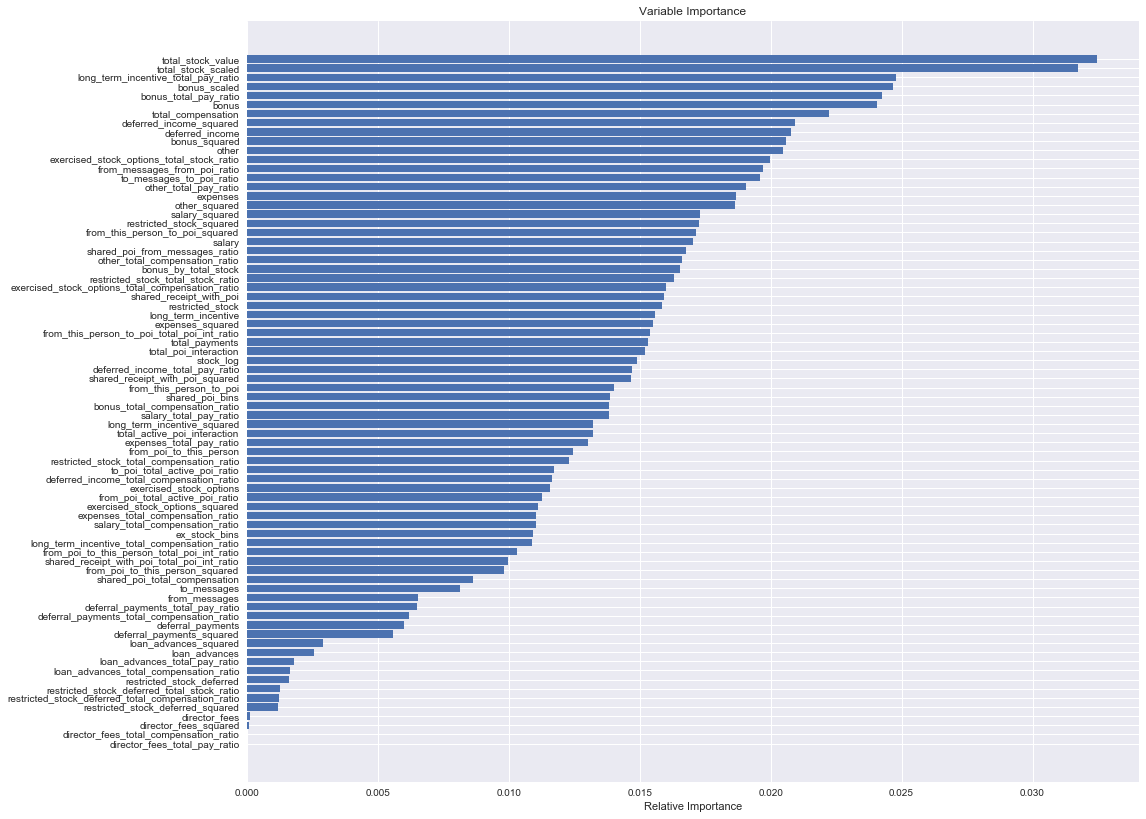

In [88]:
#all_cols2 = np.concatenate([all_cols, np.array(['shared_poi_bins', 'ex_stock_bins', 
#                                                'total_stock_scaled', 'bonus_scaled',
#                                                'stock_log'])])
# from_messages_from_poi_to_ratio

features = np.array(df.drop('poi', axis=1).columns)

clf = ExtraTreesClassifier(n_estimators=3000)
clf.fit(df[features], df['poi'])

importances = clf.feature_importances_
sorted_idx = np.argsort(importances)

padding = np.arange(len(features)) + 0.5
plt.figure(figsize=(16,14))
plt.barh(padding, importances[sorted_idx], align='center')
plt.yticks(padding, features[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

top10_features_RF = ['bonus', 'total_stock_value', 'other', 'total_compensation', 'expenses',
                 'other_total_pay_ratio', 'from_messages_from_poi_ratio', 'restricted_stock',
                 'shared_poi_from_messages_ratio', 'total_payments']

top10_features_ET = ['exercised_stock_options_squared', 'total_stock_value', 'bonus_total_pay_ratio', 
                     'long_term_incentive_total_pay_ratio', 'bonus', 'deferred_income',
                     'total_compensation', 'to_messages_to_poi_ratio',
                     'from_messages_from_poi_ratio', 'to_messages_to_poi_ratio', 'other_total_pay_ratio',
                     'salary_squared', 'other']

In [89]:
confusion_matrix(df['poi'], clf.predict(df[features]))

array([[127,   0],
       [  0,  18]])

In [90]:
#X_df = df.drop('poi', axis=1)
#y_df = df['poi']
#selector = SelectKBest(k=12, score_func=f_classif)
#selector = selector.fit_transform(X_df, y_df)
#selector

# Train

In [91]:
FINANCIAL_FIELDS = ['salary', 'deferral_payments', 'total_payments', 'exercised_stock_options', 
                  'bonus', 'restricted_stock', 'restricted_stock_deferred', 'total_stock_value',
                  'expenses', 'loan_advances', 'other', 'director_fees', 'deferred_income', 
                  'long_term_incentive', 'ex_stock_bins', 'stock_log']

EMAIL_FIELDS = ['from_messages', 'to_messages', 'shared_receipt_with_poi', 
              'from_this_person_to_poi', 'from_poi_to_this_person', 'email_address',
              'shared_poi_bins']

In [92]:
class ColumnExtractor(TransformerMixin):
    '''
    Columns extractor transformer for sklearn pipelines.
    Inherits fit_transform() from TransformerMixin, but this is explicitly
    defined here for clarity.
    
    Methods to extract pandas dataframe columns are defined for this class.
    
    '''
    def __init__(self, columns=[]):
        self.columns = columns
    
    def fit_transform(self, X, y=None, **fit_params):
        self.fit(X, y, **fit_params)
        return self.transform(X)
    
    def transform(self, X, **transform_params):
        '''
        Input: A pandas dataframe and a list of column names to extract.
        Output: A pandas dataframe containing only the columns of the names passed in.
        '''
        return X[self.columns]
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def get_params(self, deep=True):
        """Get parameters for this estimator.
        Parameters
        ----------
        deep: boolean, optional
            If True, will return the parameters for this estimator and
            contained subobjects that are estimators.
        Returns
        -------
        params : mapping of string to any
            Parameter names mapped to their values.
        """

        return self

In [93]:
top10_features_ET
top10 = ['exercised_stock_options', 'total_stock_value', 'bonus', 'salary', 'deferred_income', 
        'long_term_incentive', 'restricted_stock', 'total_payments', 'loan_advances',
         'shared_receipt_with_poi','total_compensation', 'from_messages_from_poi_ratio']

In [ ]:
#X_df = df[['total_payments', 'total_stock_value', 'shared_receipt_with_poi', 'bonus']].astype(float)
X_df = df.drop('poi', axis=1).astype(float)
#X_df = df[top10_features_ET]

#X_df = df[topKBest].astype(float)
y_df = df['poi']

y_df = y_df[X_df.abs().sum(axis=1) != 0]
X_df = X_df[X_df.abs().sum(axis=1) != 0]





sk_fold = StratifiedShuffleSplit(y_df, n_iter=100, test_size=0.1) 
        
pipeline = Pipeline(steps=[#('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy="median", verbose=0)),
                           #('standardizer', StandardScaler(copy=True, with_mean=True, with_std=True)),
                           ('minmaxer', MinMaxScaler()),
                           #('low_var_remover', VarianceThreshold()),
                           ('selection', SelectKBest(score_func=f_classif)),
                           ('reducer', PCA()),
                           #('classifier', LinearSVC(penalty='l1', dual=False)),
                           #('KMeans', KMeans(n_clusters=2))
                           ('classifier', LogisticRegression())
                           #('classifier2', SGDClassifier(n_iter=300))
                                                     ]) # ,
                           #('ET', ExtraTreesClassifier(bootstrap=True, compute_importances=None,
                           #                            criterion='gini', n_estimators=1500, n_jobs=1,
                           #                            oob_score=True, random_state=None, verbose=0,
                           #                            max_features='auto', min_samples_split=2,
                           #                            min_samples_leaf=1))])

                    
params = {
          #'ET__n_estimators': [1500],
          #'ET__max_features': ['auto', None, 3, 5, 10, 20],
          #'ET__min_samples_split': [2, 4, 10],
          #'ET__min_samples_leaf': [1, 2, 5],
          'selection__k': [20, 17, 15],
          'classifier__C': [1, 10, 100, 1000],
          #'classifier2__alpha': [0.0001, 0.001],
          #'classifier2__loss': ['hinge', 'log', 'modified_huber'],
          #'classifier2__class_weight': [{True: 4, False: 1}, {True: 10, False: 1}],
          #'classifier__penalty': ['l1', 'l2'],
          'classifier__class_weight': [{True: 12, False: 1}, {True: 10, False: 1}, {True: 8, False: 1}],
          'classifier__tol': [1e-1, 1e-2, 1e-4, 1e-8, 1e-16, 1e-32],
          'reducer__n_components': [1, 2, 3, 4, 5],
          'reducer__whiten': [True, False]
          #'feature_selection__k': [3, 5, 10, 20]
          #'ET__criterion' : ['gini', 'entropy'],
          #'imputer__strategy': ['median', 'mean'],
          #'low_var_remover__threshold': [0, 0.1, .25, .50, .75, .90, .99]
          }
# Scoring: average_precision, roc_auc, f1, recall, precision
grid_search = GridSearchCV(pipeline, param_grid=params, cv=sk_fold, n_jobs = -1, scoring='f1', verbose=True)
grid_search.fit(X_df, y=y_df)
#test_pred = grid_search.predict(X_test)
#print "Cross_Val_score: ", cross_val_score(grid_search, X_train, y_train)
print ("Best Estimator: ", grid_search.best_estimator_)
    #f1_avg.append(f1_score(y_test, test_pred))
#print "F1: ", f1_score(y_test, test_pred)
#print "Confusion Matrix: "
#print confusion_matrix(y_test, test_pred)
#print "Accuracy Score: ", accuracy_score(y_test, test_pred)
print ("Best Params: ", grid_search.best_params_)

Fitting 100 folds for each of 2160 candidates, totalling 216000 fits


[Parallel(n_jobs=-1)]: Done 416 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 2216 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 5216 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done 9416 tasks      | elapsed:   52.7s
[Parallel(n_jobs=-1)]: Done 14816 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 21416 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 29216 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 38216 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 48416 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 59816 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 72416 tasks      | elapsed: 11.4min
[Parallel(n_jobs=-1)]: Done 86216 tasks      | elapsed: 14.4min
[Parallel(n_jobs=-1)]: Done 101216 tasks      | elapsed: 16.6min
[Parallel(n_jobs=-1)]: Done 117416 tasks      | elapsed: 18.5min
[Parallel(n_jobs=-1)]: Done 134816 tasks      | elapsed: 20.5min


In [ ]:
n_iter = 1000
sk_fold = StratifiedShuffleSplit(y_df, n_iter=n_iter, test_size=0.1)
f1_avg = []
recall_avg = []
precision_avg = []
for i, all_index in enumerate(sk_fold):
    train_index = all_index[0]
    test_index = all_index[1]
    X_train, X_test = X_df.irow(train_index), X_df.irow(test_index)
    y_train, y_test = y_df[train_index], y_df[test_index]

    grid_search.best_estimator_.fit(X_train, y=y_train)
    # pipeline.fit(X_train, y=y_train)
    test_pred = grid_search.predict(X_test)
    #test_pred = pipeline.predict(X_test)

    #print "Cross_Val_score: ", cross_val_score(grid_search, X_train, y_train)
    #print "Best Estimator: ", grid_search.best_estimator_
    #print f1_score(y_test, test_pred)
    if i % round(n_iter/10) == 0:
        sys.stdout.write('{0}%..'.format(float(i)/n_iter*100)) 
        sys.stdout.flush()        
    f1_avg.append(f1_score(y_test, test_pred))
    precision_avg.append(precision_score(y_test, test_pred))
    recall_avg.append(recall_score(y_test, test_pred))

print "Done!"
print ""
print "F1 Avg: ", sum(f1_avg)/n_iter
print "Precision Avg: ", sum(precision_avg)/n_iter
print "Recall Avg: ", sum(recall_avg)/n_iter

F1 Avg:  0.309882173382
Precision Avg:  0.226065462315
Recall Avg:  0.5515
---------------------
Best Estimator:  Pipeline(steps=[('standardizer', StandardScaler(copy=True, with_mean=True, with_std=True)), ('low_var_remover', VarianceThreshold(threshold=0.1)), ('classifier', LinearSVC(C=0.1, class_weight='auto', dual=False, fit_intercept=True,
     intercept_scaling=1, loss='l2', multi_class='ovr', penalty='l1',
     random_state=None, tol=1e-07, verbose=0))])
Best Params:  {'classifier__class_weight': 'auto', 'low_var_remover__threshold': 0.1, 'classifier__C': 0.1, 'classifier__tol': 1e-07}


F1 Avg:  0.39108035853
Precision Avg:  0.263075613276
Recall Avg:  0.8335
----------------------
Best Estimator:  Pipeline(steps=[('minmaxer', MinMaxScaler(copy=True, feature_range=(0, 1))), ('reducer', PCA(copy=True, n_components=5, whiten=True)), ('classifier', LogisticRegression(C=0.01, class_weight='auto', dual=False,
          fit_intercept=True, intercept_scaling=1, penalty='l2',
          random_state=None, tol=0.01))])
Best Params:  {'reducer__whiten': True, 'classifier__class_weight': 'auto', 'classifier__C': 0.01, 'reducer__n_components': 5, 'classifier__tol': 0.01}


F1 Avg:  0.408565806416
Precision Avg:  0.301739249639
Recall Avg:  0.725
------------------------
Best Estimator:  Pipeline(steps=[('minmaxer', MinMaxScaler(copy=True, feature_range=(0, 1))), ('reducer', PCA(copy=True, n_components=5, whiten=False)), ('classifier2', SGDClassifier(alpha=0.0001, class_weight='auto', epsilon=0.1, eta0=0.0,
       fit_intercept=True, l1_ratio=0.15, learning_rate='optimal',
       loss='hinge', n_iter=300, n_jobs=1, penalty='elasticnet',
       power_t=0.5, random_state=None, shuffle=False, verbose=0,
       warm_start=False))])
Best Params:  {'reducer__n_components': 5, 'classifier2__alpha': 0.0001, 'classifier2__class_weight': 'auto', 'classifier2__loss': 'hinge', 'reducer__whiten': False, 'classifier2__penalty': 'elasticnet'}

F1 Avg:  0.293634931735
Precision Avg:  0.219107395382
Recall Avg:  0.5055
-------
Best Estimator:  Pipeline(steps=[('minmaxer', MinMaxScaler(copy=True, feature_range=(0, 1))), ('classifier', LinearSVC(C=1, class_weight='auto', dual=False, fit_intercept=True,
     intercept_scaling=1, loss='l2', multi_class='ovr', penalty='l1',
     random_state=None, tol=1e-08, verbose=0)), ('classifier2', SGDClassifier(a..., penalty='l2', power_t=0.5,
       random_state=None, shuffle=False, verbose=0, warm_start=False))])
Best Params:  {'classifier2__alpha': 0.001, 'classifier__class_weight': 'auto', 'classifier2__class_weight': 'auto', 'classifier2__loss': 'hinge', 'classifier__tol': 1e-08, 'classifier2__penalty': 'l2', 'classifier__C': 1}

F1 Avg:  0.392249062049
Precision Avg:  0.300678174603
Recall Avg:  0.636
------
Best Estimator:  Pipeline(steps=[('minmaxer', MinMaxScaler(copy=True, feature_range=(0, 1))), ('reducer', PCA(copy=True, n_components=4, whiten=True)), ('classifier', LogisticRegression(C=10, class_weight='auto', dual=False, fit_intercept=True,
          intercept_scaling=1, penalty='l2', random_state=None, tol=0.0001))])
Best Params:  {'reducer__n_components': 4, 'classifier__class_weight': 'auto', 'classifier__tol': 0.0001, 'reducer__whiten': True, 'classifier__C': 10, 'classifier__penalty': 'l2'}

F1 Avg:  0.461406277056
Precision Avg:  0.364574206349
Recall Avg:  0.7095
------
Best Estimator:  Pipeline(steps=[('minmaxer', MinMaxScaler(copy=True, feature_range=(0, 1))), ('reducer', PCA(copy=True, n_components=1, whiten=True)), ('classifier', LogisticRegression(C=100, class_weight={False: 1, True: 8}, dual=False,
          fit_intercept=True, intercept_scaling=1, penalty='l2',
          random_state=None, tol=0.1))])
Best Params:  {'reducer__whiten': True, 'classifier__class_weight': {False: 1, True: 8}, 'classifier__C': 100, 'reducer__n_components': 1, 'classifier__tol': 0.1}

In [ ]:
pipeline = Pipeline(steps=[#('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)),
                           #('standardizer', StandardScaler(copy=True, with_mean=True, with_std=True)),
                           #('low_var_remover', VarianceThreshold(threshold=0.1)), 
                           #('feature_selection', LinearSVC()),
                           ('features', FeatureUnion([
                                ('financial', Pipeline([
                                    ('extract', ColumnExtractor(FINANCIAL_FIELDS)),
                                    ('scale', StandardScaler()),
                                    ('reduce', LinearSVC())
                                ])),

                                ('email', Pipeline([
                                    ('extract2', ColumnExtractor(EMAIL_FIELDS)),
                                    ('scale2', StandardScaler()),
                                    ('reduce2', LinearSVC())
                                ]))

                            ])),
                           ('ET', ExtraTreesClassifier(bootstrap=True, compute_importances=None,
                                                       criterion='gini', n_estimators=1500, n_jobs=1,
                                                       oob_score=True, random_state=None, verbose=0,
                                                       max_features=None, min_samples_split=2,
                                                       min_samples_leaf=1))
                            ])

In [ ]:
PERF_FORMAT_STRING = "\
\tAccuracy: {:>0.{display_precision}f}\tPrecision: {:>0.{display_precision}f}\t\
Recall: {:>0.{display_precision}f}\tF1: {:>0.{display_precision}f}\tF2: {:>0.{display_precision}f}"
RESULTS_FORMAT_STRING = "\tTotal predictions: {:4d}\tTrue positives: {:4d}\tFalse positives: {:4d}\tFalse negatives: {:4d}\tTrue negatives: {:4d}"


def test_classifier(clf, dataset, feature_list, folds = 1000):
    #data = featureFormat(dataset, feature_list, sort_keys = True)
    #labels, features = targetFeatureSplit(data)
    labels = y_df
    features = X_df
    cv = StratifiedShuffleSplit(labels, n_iter=folds, random_state = 42)
    true_negatives = 0
    false_negatives = 0
    true_positives = 0
    false_positives = 0
    for train_idx, test_idx in cv: 
        features_train = []
        features_test  = []
        labels_train   = []
        labels_test    = []
        #for ii in train_idx:
        #    features_train.append( features[ii] )
        #    labels_train.append( labels[ii] )
        #for jj in test_idx:
        #    features_test.append( features[jj] )
        #    labels_test.append( labels[jj] )
        features_train, features_test = features.irow(train_index), features.irow(test_index)
        labels_train, labels_test = labels[train_index], labels[test_index]
        ### fit the classifier using training set, and test on test set
        clf.fit(features_train, labels_train)
        predictions = clf.predict(features_test)

        for prediction, truth in zip(predictions, labels_test):
            if prediction == 0 and truth == 0:
                true_negatives += 1
            elif prediction == 0 and truth == 1:
                false_negatives += 1
            elif prediction == 1 and truth == 0:
                false_positives += 1
            else:
                true_positives += 1
    try:
        total_predictions = true_negatives + false_negatives + false_positives + true_positives

        accuracy = 1.0*(true_positives + true_negatives)/total_predictions
        
        precision = 1.0*true_positives/(true_positives+false_positives)
        
        recall = 1.0*true_positives/(true_positives+false_negatives)
        
        f1 = 2.0 * true_positives/(2*true_positives + false_positives+false_negatives)
       
        f2 = (1+2.0*2.0) * precision*recall/(4*precision + recall)

        print clf
        print ""
        print PERF_FORMAT_STRING.format(accuracy, precision, recall, f1, f2, display_precision = 5)

        print RESULTS_FORMAT_STRING.format(total_predictions, true_positives, false_positives, false_negatives, true_negatives)
        print ""
    except:
        print "Got a divide by zero when trying out:", clf

In [ ]:
clf = Pipeline(steps=[('minmaxer', MinMaxScaler(copy=True, feature_range=(0, 1))), 
                      ('reducer', PCA(copy=True, n_components=4, whiten=True)), 
                      ('classifier', LogisticRegression(C=10, class_weight='auto',
                                                        dual=False, fit_intercept=True,
                                                        intercept_scaling=1, penalty='l2',
                                                        random_state=None, tol=0.0001))])

In [ ]:
#test_classifier(clf, None, None, folds=1000)
test_classifier(grid_search.best_estimator_, None, None, folds=1000)

In [ ]:
#test_classifier(clf, None, None, folds=1000)

In [ ]:
#!/usr/bin/python

import sys
import pickle
sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import test_classifier, dump_classifier_and_data

### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
features_list = ['poi','salary'] # You will need to use more features

### Load the dictionary containing the dataset
data_dict = pickle.load(open("final_project_dataset.pkl", "r") )

### Task 2: Remove outliers
### Task 3: Create new feature(s)
### Store to my_dataset for easy export below.
my_dataset = data_dict

### Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

### Task 4: Try a varity of classifiers
### Please name your classifier clf for easy export below.
### Note that if you want to do PCA or other multi-stage operations,
### you'll need to use Pipelines. For more info:
### http://scikit-learn.org/stable/modules/pipeline.html

from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()    # Provided to give you a starting point. Try a varity of classifiers.

### Task 5: Tune your classifier to achieve better than .3 precision and recall 
### using our testing script.
### Because of the small size of the dataset, the script uses stratified
### shuffle split cross validation. For more info: 
### http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html

test_classifier(clf, my_dataset, features_list)

### Dump your classifier, dataset, and features_list so 
### anyone can run/check your results.

dump_classifier_and_data(clf, my_dataset, features_list)